In [1]:
from datetime import datetime
from fredapi import Fred
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import pytz
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
import yfinance as yf

# Connect to yfinance and collect data
def yf_data():

    tickers = {
    '^GSPC': 'SPY',
    '^VIX': 'VIX',
    '^DJI': 'DJI',
    '^IXIC': 'Nasdaq',
    '^RUT': 'RUSSELL 2000',
    '^GDAXI': 'DAX',
    '^FTSE': 'FTSE',
    '^FCHI': 'CAC',
    '^HSI': 'HSI',
    '000001.SS': 'SSE',
    '^N225': 'Nikkei',
    'XLE': 'ENERGY',
    'XLF': 'FINANCIALS',
    'XLK': 'TECHNOLOGY',
    'XLV': 'HEALTHCARE',
    'XLP': 'CONSUMER STAPLES',
    'XLI': 'INDUSTRIALS',
    'XLU': 'UTLITIES',
    'XLY': 'CONSUMER DISCRETIONARY',
    'XLB': 'MATERIALS',
    '^FVX': '5Y YIELD',
    '^TNX': '10Y YIELD',
    '^TYX': '30Y YIELD',
}
    daily_returns_df = pd.DataFrame()

    utc_tz = pytz.timezone('Etc/UTC')

    for symbol, name in tickers.items():
        ticker_data = yf.download(symbol, interval='1d', start="2003-01-01", end="2023-01-07")['Close']
        ticker_data.index = ticker_data.index.tz_localize('UTC').tz_convert(utc_tz)
        # Calculate daily return from close
        daily_returns = ticker_data.pct_change().apply(lambda x: np.log(1 + x)) * 100
        daily_returns_df[name] = daily_returns
        
        # Forward fill NaN values
        filled_daily_returns_df = daily_returns_df.ffill()
        # Drop remaining NaN values
        filtered_daily_returns_df = filled_daily_returns_df.dropna()
        

    return filtered_daily_returns_df

# collect spy volume and other TA
def spy_ta():
    tickers = ['SPY']
    start_date = '2003-01-01'
    end_date = '2023-01-07'

    # Fetch historical data from Yahoo Finance
    data = yf.download(tickers, start=start_date, end=end_date)
    volume = yf.download(tickers, start=start_date, end=end_date)['Volume']

    # Convert index to UTC timezone
    utc_tz = pytz.timezone('Etc/UTC')
    data.index = data.index.tz_localize('UTC').tz_convert(utc_tz)
    volume.index = volume.index.tz_localize('UTC').tz_convert(utc_tz)
    data = pd.DataFrame(data)
    volume = pd.DataFrame(volume)

    # simple moving average for 5,10,20 days
    data.ta.sma(length=5, append=True)
    data.ta.sma(length=10, append=True)
    data.ta.sma(length=20, append=True)
    # exponential moving average for 5,10,20 days
    data.ta.ema(length=5, append=True)
    data.ta.ema(length=10, append=True)
    data.ta.ema(length=20, append=True)
    # rsi for 7,14,20 days
    data.ta.rsi(length=7, append=True)
    data.ta.rsi(length=14, append=True)
    data.ta.rsi(length=20, append=True)
    # atr for 14 days
    data.ta.atr(length=14, append=True)
    data.ta.obv(high='high', low='low', close='close', volume='volume', append=True)
    

    ta_data = pd.concat([data, volume], axis=1)

    return ta_data

    
# Connect to FRED and collect economic data
def fed_data():

    indicators = {
        'CPIAUCSL': 'CPI',
        'MEDCPIM158SFRBCLE': 'MEDIAN CPI',
        'STICKCPIM157SFRBATL': 'STICKY CPI',
        'PCE': 'PCE',
        'PSAVERT': 'PERSONAL SAVINGS',
        'PPIACO': 'PPI (ALL COMMODITIES)',
        'T10YIE': '10Y EXPECTED INFLATION',
        'T5YIE' : '5Y EXPECTED INFLATION',
        'EXPINF1YR': '1Y EXPECTED INFLATION',
        'EXPINF2YR': '2Y EXPECTED INFLATION',
        'DCOILBRENTEU': 'BRENT',
        'DCOILWTICO': 'WTI',
        'T10Y2Y': '10Y-2Y: YIELD CURVE',
        'DGS1MO': '1M TBILL',
        'DTB3': '3M TBILL',
        'RPTTLD': 'FED OPEN MARKET OPERATIONS: TOTAL SECURITIES',
        'M1SL': 'M1',
        'WM2NS': 'M2',
        'BAMLC0A1CAAAEY': 'AAA YIELD',
        'USALORSGPNOSTSAM': 'US GDP',
        'GEPUCURRENT': 'POLICY UNCERTAINTY INDEX',
        'TLRESCONS': 'RESIDENTIAL CONSTRUCTION SPENDING',
        'HOUST': 'NEW PRIVATE HOUSING',
    }
    utc_tz = pytz.timezone('Etc/UTC')

    fred = Fred(api_key='7cdaa2609ea03808ab1cd13fcb0ad384')
    indicator_data_dict = {}

    for tag, indicator_name in indicators.items():
        data = fred.get_series_latest_release(tag)
        data.index = pd.to_datetime(data.index).tz_localize('UTC').tz_convert(utc_tz)
        indicator_data_dict[indicator_name] = data

    # Concatenate data and forward fill NaN values
    indicator_data_df = pd.concat(indicator_data_dict.values(), axis=1, keys=indicator_data_dict.keys())
    indicator_data_df.ffill(inplace=True)

    # Filter data for the desired date range
    start_date = datetime(2003, 1, 1).replace(tzinfo=utc_tz)
    end_date = datetime(2023, 1, 1).replace(tzinfo=utc_tz)
    indicator_data_df = indicator_data_df.loc[start_date:end_date]
    return indicator_data_df

# connect to mt5 and collect forex data
def collect_forex_data():
    forex_symbols = ['EURUSD', 'USDJPY', 'AUDUSD', 'USDCAD']
    forex_dataframes = []
    # set dates to utc
    timezone = pytz.timezone("Etc/UTC")
    start_date = datetime(2003, 1, 1)
    end_date = datetime(2023, 1, 2)
    utc_from = datetime(start_date.year, start_date.month, start_date.day, tzinfo=timezone)
    utc_to = datetime(end_date.year, end_date.month, end_date.day, hour=23, minute=59, second=59, tzinfo=timezone)
    
    timezone = pytz.timezone("Etc/UTC")
    start_date = datetime(2003, 1, 1)
    end_date = datetime(2023, 1, 2)
    utc_from = timezone.localize(datetime(start_date.year, start_date.month, start_date.day))
    utc_to = timezone.localize(datetime(end_date.year, end_date.month, end_date.day, hour=23, minute=59, second=59))
    
    for symbol in forex_symbols:
        mt5.initialize()
        forex_data = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, utc_from, utc_to)
        forex_df = pd.DataFrame(forex_data, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])
        forex_df['time'] = pd.to_datetime(forex_df['time'], unit='s')
        forex_df['time'] = forex_df['time'].dt.tz_localize(timezone)  # Localize the time column
        forex_df.set_index('time', inplace=True)
        symbol_close = forex_df['close']
        symbol_returns = symbol_close.pct_change() * 100
        symbol_returns = symbol_returns.rename(f'{symbol}')
        # ffill Nan values
        symbol_returns = symbol_returns.ffill()
        # drop remaining Nan
        symbol_returns = symbol_returns.dropna()
        forex_dataframes.append(symbol_returns)
        mt5.shutdown()

    return pd.concat(forex_dataframes, axis=1)

# correlation analysis
def correlation_test(dataframe):
    correlation_matrix = dataframe.corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

# stationarize data
#def station_data(dataframe):
    #for column in dataframe.columns:
        # Perform seasonal adjustment
        #decomposition = seasonal_decompose(dataframe[column], model='additive', period=1)
        #dataframe[column + '_seasonally_adjusted'] = decomposition.trend

        # Differencing to make the series stationary
        #dataframe[column + '_stationary'] = dataframe[column + '_seasonally_adjusted'].diff()

    # Drop NaN values resulted from differencing
    #dataframe = dataframe.dropna()

    #return dataframe

# adf test for market data
def adf_test(dataframe):
    results = {}
    for column in dataframe.columns:
        adf_result = adfuller(dataframe[column])
        results[column] = {
            'Test Statistic': adf_result[0],
            'P-Value': adf_result[1],
            'Lags Used': adf_result[2],
            'Number of Observations Used': adf_result[3],
            'Critical Values': adf_result[4]
        }
    
    adf_results_df = pd.DataFrame(results).T
    return adf_results_df

# principal component analysis if needed
def apply_pca(dataframe):
    features = dataframe.drop(columns='SPY')
    # apply standardization 
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=0.95)
    features_pca = pca.fit_transform(scaled_features)

    # Check the explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:", explained_variance_ratio)

    # Check the cumulative explained variance
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    print("Cumulative Explained Variance:", cumulative_explained_variance)

    # plot for explained variance
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
    plt.title('Screen Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

    # plot for cumulative variance
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
    plt.title('Cumulative Explained Variance Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

    return features_pca



In [2]:
# equities data
filtered_daily_return_df = yf_data()
print(filtered_daily_return_df)
# adf test on equity data
equity_adf_results = adf_test(filtered_daily_return_df)
print(equity_adf_results)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
# macroeconomic data
indicator_data_df = fed_data()
indicator_data_df = indicator_data_df.dropna()

# adf test
indicator_adf_results = adf_test(indicator_data_df)
print(indicator_adf_results)


                                             Test Statistic   P-Value  \
CPI                                                2.048533  0.998733   
MEDIAN CPI                                        -2.179906  0.213619   
STICKY CPI                                        -3.893352  0.002084   
PCE                                                1.039035  0.994661   
PERSONAL SAVINGS                                    -3.6131  0.005515   
PPI (ALL COMMODITIES)                             -0.496023   0.89279   
10Y EXPECTED INFLATION                            -3.394072  0.011163   
5Y EXPECTED INFLATION                             -3.866586  0.002295   
1Y EXPECTED INFLATION                             -4.121926  0.000891   
2Y EXPECTED INFLATION                             -3.230447  0.018289   
BRENT                                             -2.580596  0.097074   
WTI                                               -2.903629  0.044928   
10Y-2Y: YIELD CURVE                               -

In [4]:
# forex data
forex_data = collect_forex_data()
forex_data = forex_data.dropna()
# adf test
forex_adf_results = adf_test(forex_data)
print(forex_adf_results)

       Test Statistic P-Value Lags Used Number of Observations Used  \
EURUSD     -73.202002     0.0         0                        5195   
USDJPY     -74.835711     0.0         0                        5195   
AUDUSD     -24.757083     0.0         8                        5187   
USDCAD     -12.438461     0.0        32                        5163   

                                          Critical Values  
EURUSD  {'1%': -3.4316093905923193, '5%': -2.862096519...  
USDJPY  {'1%': -3.4316093905923193, '5%': -2.862096519...  
AUDUSD  {'1%': -3.4316113339347782, '5%': -2.862097377...  
USDCAD  {'1%': -3.4316172001143523, '5%': -2.862099969...  


In [5]:
# technical analysis features
ta_data = spy_ta()
print(ta_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                                 Open        High         Low       Close  \
Date                                                                        
2003-01-02 00:00:00+00:00   88.849998   91.300003   88.540001   91.070000   
2003-01-03 00:00:00+00:00   90.910004   91.379997   90.500000   91.349998   
2003-01-06 00:00:00+00:00   91.239998   93.489998   91.169998   92.959999   
2003-01-07 00:00:00+00:00   92.900002   93.370003   92.199997   92.730003   
2003-01-08 00:00:00+00:00   92.199997   92.400002   91.050003   91.389999   
...                               ...         ...         ...         ...   
2022-12-30 00:00:00+00:00  380.640015  382.579987  378.429993  382.429993   
2023-01-03 00:00:00+00:00  384.369995  386.429993  377.829987  380.820007   
2023-01-04 00:00:00+00:00  383.179993  385.880005  380.000000  383.760010   
2023-01-05 00:0

In [6]:
# combine all data
combined_data = pd.concat([filtered_daily_return_df, indicator_data_df, forex_data, ta_data], axis=1)
clean_combined_data = combined_data.dropna()


Explained Variance Ratio: [0.28433233 0.19085781 0.10922493 0.05949127 0.04831452 0.04076847
 0.03023232 0.02542634 0.02300845 0.01772907 0.01669104 0.0137541
 0.01134156 0.0111172  0.01087526 0.00958773 0.00909692 0.00777975
 0.00702723 0.00681383 0.00624497 0.00563304 0.00457941 0.00432764]
Cumulative Explained Variance: [0.28433233 0.47519014 0.58441507 0.64390635 0.69222087 0.73298934
 0.76322165 0.78864799 0.81165644 0.82938552 0.84607656 0.85983066
 0.87117222 0.88228943 0.89316468 0.90275241 0.91184933 0.91962908
 0.92665631 0.93347014 0.93971511 0.94534815 0.94992756 0.9542552 ]


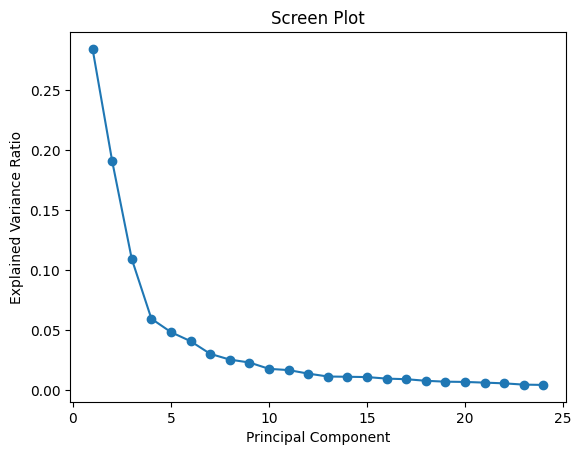

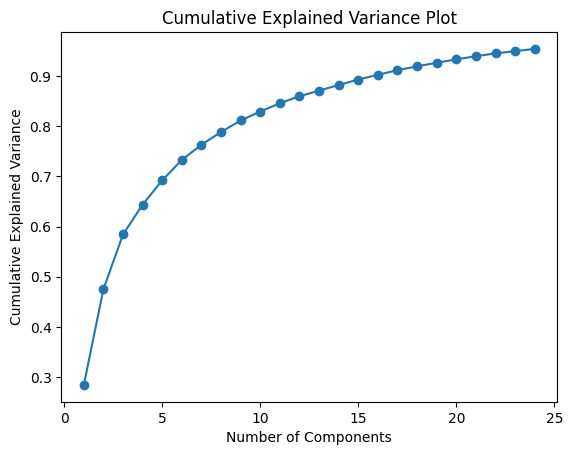

In [7]:
# apply pca
feature_pca = apply_pca(clean_combined_data)

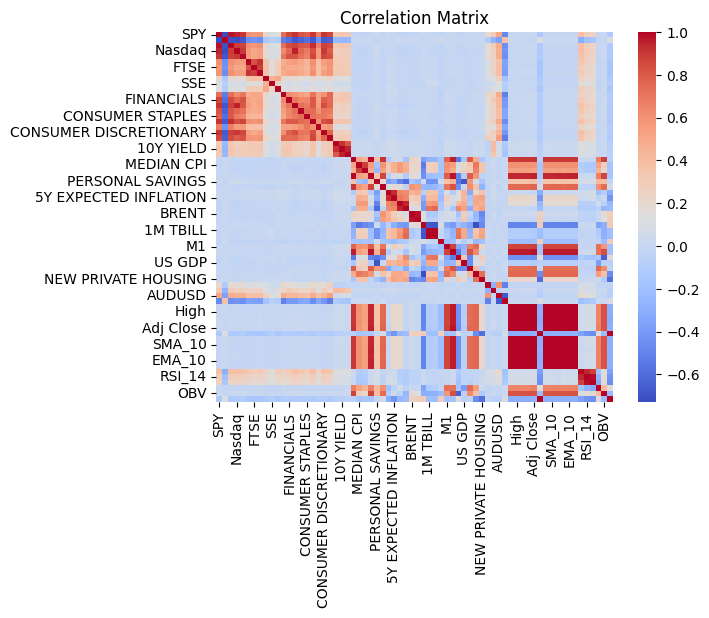

In [8]:
# create correlation heatmap
heatmap = correlation_test(clean_combined_data)

In [9]:
# split data into training, validation, test
column_indices = {name: i for i, name in enumerate(clean_combined_data)}

n = len(clean_combined_data)
train_df = clean_combined_data[0:int(n*0.7)]
val_df = clean_combined_data[int(n*0.7):int(n*0.9)]
test_df = clean_combined_data[int(n*0.9):]

num_features = clean_combined_data.shape[1]

# normalise data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std



In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# input width = how far back in time, label width = number of target data prediction, shift = how far into future to predict
w1 = WindowGenerator(input_width=30, label_width=1, shift=30,
                     label_columns=['SPY'])

w2 = WindowGenerator(input_width=7, label_width=1, shift=1,
                     label_columns=['SPY'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 68)
Inputs shape: (3, 7, 68)
Labels shape: (3, 1, 1)


In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [14]:
# plot function for visualisation of lstm model
def plot(self, model=None, plot_col='SPY', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [Days]')

WindowGenerator.plot = plot



Epoch 1/20

109/109 [==============================] - 19s 90ms/step - loss: 0.9773 - mean_absolute_error: 0.6467 - val_loss: 1.2252 - val_mean_absolute_error: 0.6307
Epoch 2/20
109/109 [==============================] - 9s 78ms/step - loss: 0.8203 - mean_absolute_error: 0.6182 - val_loss: 1.2357 - val_mean_absolute_error: 0.6620
Epoch 3/20
31/31 [==============================] - 1s 34ms/step - loss: 1.2624 - mean_absolute_error: 0.6549
[1.0855954885482788, 0.7790769338607788] [1.04191914 0.88265335]
15/15 [==============================] - 2s 34ms/step
[[[ 0.03170054]
  [ 0.03472404]
  [ 0.06042168]
  ...
  [ 0.04060341]
  [ 0.01971438]
  [ 0.01185734]]

 [[-0.00519352]
  [-0.01166141]
  [-0.01329932]
  ...
  [ 0.26521567]
  [ 0.27445877]
  [ 0.29014987]]

 [[ 0.00695475]
  [ 0.00158432]
  [ 0.01905136]
  ...
  [ 0.22729433]
  [ 0.19675972]
  [ 0.20223972]]

 ...

 [[ 0.01225173]
  [ 0.03418637]
  [ 0.05206493]
  ...
  [ 0.29211968]
  [ 0.32424662]
  [ 0.3427482 ]]

 [[-0.00405556]


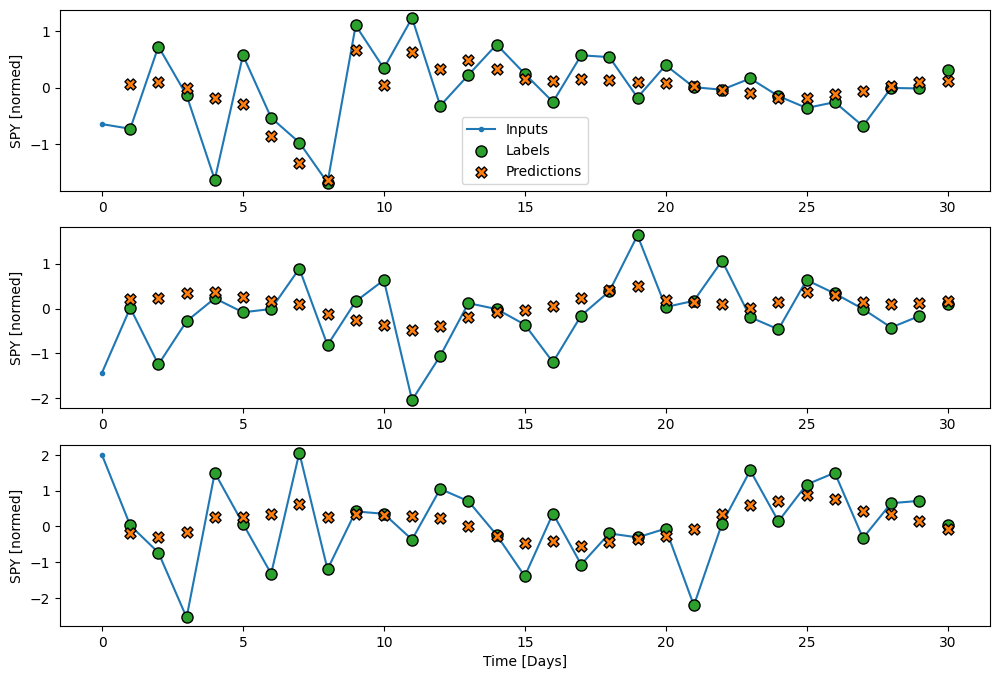

In [15]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, learning_rate, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

lstm_model = model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
    
])


wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['SPY'])

history = compile_and_fit(lstm_model, wide_window, learning_rate=0.001)


val_performance = lstm_model.evaluate(wide_window.val)
performance = lstm_model.evaluate(wide_window.test, verbose=0)

print(performance, np.sqrt(performance))

# Predict future values
predictions = lstm_model.predict(wide_window.test)

print(predictions)

wide_window.plot(lstm_model)



In [16]:
# keras hypertuner
import keras_tuner as kt

def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(return_sequences=True))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.LSTM(units=hp_units, return_sequences=True))
  model.add(tf.keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

TypeError: LSTM.__init__() missing 1 required positional argument: 'units'

In [ ]:
# features and target
X = clean_combined_data.drop(columns='SPY')
y = clean_combined_data['SPY']

# Test and train splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pca
pca = PCA(n_components=0.95)
X_train_transformed = pca.fit_transform(X_train_scaled)
X_test_transformed = pca.transform(X_test_scaled)

# sequence length
seq_length = 30

# convert df to tensor
X_train_tensor = tf.convert_to_tensor(X_train_transformed, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)

X_test_tensor = tf.convert_to_tensor(X_test_transformed, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)


# create tf Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))


# Batch and prefetch the datasets
batch_size = 32
train_dataset = train_dataset.window(seq_length, shift=1, drop_remainder=True)
train_dataset = train_dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(seq_length), y.batch(seq_length))))
train_dataset = train_dataset.batch(batch_size).prefetch(1)

test_dataset = test_dataset.window(seq_length, shift=1, drop_remainder=True)
test_dataset = test_dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(seq_length), y.batch(seq_length))))

# Reshape input tensors
#X_train_tensor = tf.reshape(X_train_tensor, (-1, seq_length, 113))
#X_test_tensor = tf.reshape(X_test_tensor, (-1, seq_length, 113))
#test_dataset = test_dataset.batch(batch_size).prefetch(1)

# create tf Datasets
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))

print(X_train_tensor)
print(X_train_scaled.shape)
print(train_dataset).shape

tf.Tensor(
[[ 0.04799864 -0.41470334  0.50478095 ...  0.04620418 -0.16808641
   0.06955114]
 [-0.78689104 -0.79422766 -0.55030906 ... -0.09908146 -0.02750576
  -0.0518545 ]
 [-1.0644615  -0.7196149  -0.06927203 ... -0.32237867 -0.06381845
   0.2002275 ]
 ...
 [ 0.07884752 -0.51884615  0.07796817 ...  0.05788518 -0.05643382
   0.04105881]
 [ 0.8053015   0.16638476  0.01215618 ...  0.01929986  0.05861232
  -0.00486779]
 [-0.9089118   1.7678138  -0.21615735 ...  0.04013863 -0.05334126
   0.08897963]], shape=(4012, 12), dtype=float32)
(4012, 113)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(12)),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.LSTM(units=64, return_sequences=True),
    tf.keras.layers.LSTM(units=64, return_sequences=True),    
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the TensorFlow Dataset
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Extract loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss = model.evaluate(test_dataset)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_loss, np.sqrt(test_loss)))

# Predict future values
predictions = model.predict(test_dataset)




ValueError: Input 0 of layer "lstm_108" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 12)